# Setup

In [1]:
! pip install transformers trafilatura newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.8 MB/s 
     |████████████████████████████████| 1.0 MB 63.0 MB/s 
     |████████████████████████████████| 211 kB 67.4 MB/s 
     |████████████████████████████████| 182 kB 73.8 MB/s 
     |████████████████████████████████| 7.6 MB 35.0 MB/s 
     |████████████████████████████████| 140 kB 63.9 MB/s 
     |████████████████████████████████| 837 kB 61.5 MB/s 
     |████████████████████████████████| 412 kB 53.2 MB/s 
     |████████████████████████████████| 292 kB 81.6 MB/s 
     |████████████████████████████████| 195 kB 65.5 MB/s 
     |████████████████████████████████| 81 kB 4.6 MB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 7.4 MB 15.0 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 

In [2]:
from transformers import pipeline
import trafilatura
from newspaper import Article
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Working with labeled data

In [235]:
import os
import pandas as pd
import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)
! pwd
! ls html_files_Nov-24-2022 | wc -l # Count should be 8568

/content/drive/MyDrive/url_classification
8568


In [7]:
html_files = os.listdir(HTML_FOLDER)
html_files[:5]

['https:--www.agari.com-resources?f%5B0%5D=topic%3A52&f%5B1%5D=topic%3A55&f%5B2%5D=topic%3A60&f%5B3%5D=topic%3A61&f%5B4%5D=topic%3A80&f%5B5%5D=topic%3A82&f%5B6%5D=topic%3A83&f%5B7%5D=topic%3A84&f%5B8%5D=type%3A27&f%5B9%5D=type%3A28&f%5B10%5D=.html',
 'https:--www.agari.com-resources?f%5B0%5D=topic%3A47&f%5B1%5D=topic%3A55&f%5B2%5D=topic%3A62&f%5B3%5D=topic%3A81&f%5B4%5D=type%3A28&f%5B5%5D=type%3A33&f%5B6%5D=type%3A34&f%5B7%5D=type%3A35&f%5B8%5D=type%3A38&f%5B9%5D=type%3A39&keys=&sort_bef.html',
 'https:--www.agari.com-resources?f%5B0%5D=topic%3A45&f%5B1%5D=topic%3A47&f%5B2%5D=topic%3A49&f%5B3%5D=topic%3A50&f%5B4%5D=topic%3A54&f%5B5%5D=topic%3A60&f%5B6%5D=topic%3A79&f%5B7%5D=topic%3A80&f%5B8%5D=topic%3A82&f%5B9%5D=type%3A30&f%5B10%5D.html',
 'https:--www.agari.com-resources?f%5B0%5D=topic%3A49&f%5B1%5D=topic%3A50&f%5B2%5D=topic%3A51&f%5B3%5D=topic%3A52&f%5B4%5D=topic%3A54&f%5B5%5D=topic%3A262&f%5B6%5D=type%3A30&f%5B7%5D=type%3A35&f%5B8%5D=type%3A38&f%5B9%5D=type%3A39&keys=&sort_.html',


In [ ]:
# sheet_url = "https://docs.google.com/spreadsheets/d/1P1TLbZv4-ci-LXU7_21h6fvlzxQtSb3ths4TKPqnh_s/edit#gid=0"
# url_1 = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

# df = pd.read_csv(url_1, on_bad_lines='skip')

In [466]:
df = pd.read_csv('url_classification_temporary3.csv', usecols = ['File Name', 'Label'])
df.rename(columns={'File Name': 'filename', 'Label': 'label'}, inplace=True)
df = df[~df['filename'].isna()]
print(f'Original shape: {df.shape}')
df = df[df['label'] != '-'] # Drop all irrelevant labels
df.reset_index(drop=True, inplace=True)
print(f'Final shape: {df.shape}')

# def create_df(csv_path='url_classification_temporary.csv', usecols=['File Name', 'Label']):
#   df = pd.read_csv(csv_path, usecols = usecols)
#   df.rename(columns={usecols[0]: 'filename', usecols[1]: 'label'}, inplace=True)
#   df = df[~df['filename'].isna()]
#   print(f'Original shape: {df.shape}')
#   df = df[df['label'] != '-']
#   df.reset_index(drop=True, inplace=True)
#   print(f'Final shape: {df.shape}')
#   return df

Original shape: (261, 2)
Final shape: (206, 2)


In [467]:
df.head()

,filename,label
0,http:--abilitycommerce.com-user-summit-.html,Event
1,http:--adatile.com-when-is-ada-compliance-lega...,White Paper
2,http:--adigitallamp.com-write-for-us-.html,MISC
3,http:--alistapart.com-about-contribute-.html,MISC
4,http:--blog.archive.org-2016-10-24-faqs-for-so...,Blog


In [468]:
df['label'].value_counts() # Checking labels distribution

# def target_distribution(df, normalize=False):
#   return df['label'].value_counts(normalize=normalize)

Home Page        67
Blog             48
MISC             32
Product Page     32
White Paper       7
Article           7
Event             5
Education         4
Video Content     1
Online Course     1
Q&A Page          1
About Page        1
Name: label, dtype: int64

In [469]:
df['label'].value_counts(normalize=True) # Checking labels distribution

Home Page        0.325243
Blog             0.233010
MISC             0.155340
Product Page     0.155340
White Paper      0.033981
Article          0.033981
Event            0.024272
Education        0.019417
Video Content    0.004854
Online Course    0.004854
Q&A Page         0.004854
About Page       0.004854
Name: label, dtype: float64

In [470]:
current_filenames = df['filename'].values
current_filenames[:5]

array(['http:--abilitycommerce.com-user-summit-.html',
       'http:--adatile.com-when-is-ada-compliance-legally-required-.html',
       'http:--adigitallamp.com-write-for-us-.html',
       'http:--alistapart.com-about-contribute-.html',
       'http:--blog.archive.org-2016-10-24-faqs-for-some-new-features-available-in-the-beta-wayback-machine-.html'],
      dtype=object)

In [471]:
! pwd

/content/drive/MyDrive/url_classification


In [472]:
HTML_FOLDER

'/content/drive/MyDrive/url_classification/html_files_Nov-24-2022/'

In [473]:
df['filename'].index

RangeIndex(start=0, stop=206, step=1)

In [531]:
htmls = list()

for i, filename in enumerate(current_filenames):
  try:
    with open(f'{HTML_FOLDER}{filename}') as f:
          htmls.append(f.read())
          # print(f'Done {i}')
  except FileNotFoundError:
    # print(f'File {i} not found: "{filename}"')
    print(filename)

# def read_htmls(df):
#   current_filenames = df['filename'].values

#   for i, filename in enumerate(current_filenames):
#     try:
#       with open(f'{HTML_FOLDER}{filename}') as f:
#             htmls.append(f.read())
#             # print(f'Done {i}')
#     except FileNotFoundError:
#       print(f'File {i} not found: "{filename}"')
#       # print(filename)

In [533]:
htmls[1]

'<!DOCTYPE html>\n<html dir="ltr" lang="en"\n\tprefix="og: https://ogp.me/ns#"  class="html_stretched responsive av-preloader-disabled  html_header_top html_logo_left html_main_nav_header html_menu_right html_custom html_header_sticky html_header_shrinking html_header_topbar_active html_mobile_menu_phone html_header_searchicon_disabled html_content_align_center html_header_unstick_top_disabled html_header_stretch_disabled html_minimal_header html_minimal_header_shadow html_elegant-blog html_av-submenu-hidden html_av-submenu-display-click html_av-overlay-side html_av-overlay-side-classic html_av-submenu-noclone html_entry_id_5120 av-cookies-no-cookie-consent av-no-preview av-default-lightbox html_text_menu_active av-mobile-menu-switch-default">\n<head>\n<meta charset="UTF-8" />\n\n\n<!-- mobile setting -->\n<meta name="viewport" content="width=device-width, initial-scale=1">\n\n<!-- Scripts/CSS and wp_head hook -->\n\n\t\t<!-- All in One SEO 4.2.7.1 - aioseo.com -->\n\t\t<meta name="des

In [476]:
toi_articles = list()

for html in htmls:
  toi_article = Article(url = ' ', language="en")
  toi_article.set_html(html)
  toi_article.parse()
  toi_article.nlp()
  toi_articles.append(toi_article)


# def read_articles(htmls):
#   toi_articles = list()

#   for html in htmls:
#     toi_article = Article(url = ' ', language="en")
#     toi_article.set_html(html)
#     toi_article.parse()
#     toi_article.nlp()
#     toi_articles.append(toi_article)

#   return toi_articles

In [477]:
toi_articles[0].text

"2020 User Summit\n\n*UPDATE - March 12th, 2020*\n\nWith the ongoing coverage of the seriousness of the global outbreak of the COVID-19 virus and the potential effects, we want you to know that our priority is to keep our Summit attendees safe and informed.\n\nWhile our AC User Summit is just more than a month away, we are sensitive to our clients' travel and safety. Out of an abundance of caution and concern, we have decided to cancel the 2020 User Summit in the best interest of all involved.\n\nWhile we hope that we all can and will participate in normal activities as much as possible at this time, this is a unique situation that requires extra consideration for our clients and our employees.\n\nRegistration fees will be credited back to all clients who have registered for the Summit.\n\nThank you for your patience and understanding as we work through unprecedented times together."

In [478]:
y = df['label'].tolist()
y[:5]

# def create_y(df):
#   return df['label'].tolist()

['Event', 'White Paper', 'MISC', 'MISC', 'Blog']

In [479]:
len(toi_articles)

206

In [480]:
len(y)

206

In [481]:
assert len(toi_articles) == len(y)

# Zero-shot

In [ ]:
# for j, toi_article in enumerate(toi_articles):
#   text = toi_article.title + '. ' + toi_article.summary

#   candidate_labels = ['Home Page', 'Blog', 'Product Page', 'Article', 'White Paper']

#   output = classifier(text, candidate_labels)

#   if output['scores'][0] < 0.3:
#     predicted_label = 'MISC'
#   else:
#     predicted_label = output['labels'][0]

#   print(f'Article {j} - True label: {y[j]} - Predicted label: {predicted_label}')

#   if predicted_label == y[j]:
#     print('Correctly predicted!')
#   else:
#     print('Failed to predict!')

#   for i, label in enumerate(output['labels']):
#     score = output['scores'][i]
#     print(f"{score:.2%}: {label}")

#   print('')

Article 0 - True label: Event - Predicted label: MISC
Failed to predict!
25.33%: Article
20.79%: Home Page
19.18%: Blog
18.52%: Product Page
16.18%: White Paper

Article 1 - True label: White Paper - Predicted label: Article
Failed to predict!
42.38%: Article
18.62%: Blog
17.62%: Product Page
12.70%: White Paper
8.68%: Home Page

Article 2 - True label: MISC - Predicted label: MISC
Correctly predicted!
26.29%: Article
26.14%: Blog
18.28%: Home Page
14.67%: White Paper
14.61%: Product Page

Article 3 - True label: MISC - Predicted label: Article
Failed to predict!
53.67%: Article
13.71%: Home Page
12.95%: Blog
10.30%: Product Page
9.37%: White Paper

Article 4 - True label: Blog - Predicted label: MISC
Failed to predict!
24.19%: Home Page
20.94%: Article
20.12%: White Paper
18.01%: Product Page
16.73%: Blog

Article 5 - True label: Video Content - Predicted label: MISC
Failed to predict!
29.40%: Article
24.28%: Blog
20.41%: Home Page
14.91%: White Paper
11.01%: Product Page

Article 6 -

KeyboardInterrupt: ignored

# Bag of words approach

Take into account:
1. Try TF-IDF instead of CountVectorizer
TF-IDF tend to perform better than CountVectorizer in some cases
2. Try ensemble models instead of Vanilla ML models
Bagging and Boosting models give better results than classic ML techniques in most cases
3. Better Text Preprocessing
Typo correction, Lemmatization, etc can be done to further improve the model

In [482]:
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [483]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [484]:
df.head(10)

,filename,label
0,http:--abilitycommerce.com-user-summit-.html,Event
1,http:--adatile.com-when-is-ada-compliance-lega...,White Paper
2,http:--adigitallamp.com-write-for-us-.html,MISC
3,http:--alistapart.com-about-contribute-.html,MISC
4,http:--blog.archive.org-2016-10-24-faqs-for-so...,Blog
5,http:--brainrules.net-vision-.html,Video Content
6,http:--corpina.com-best-nootropic-stack-to-rep...,Article
7,http:--credibility.stanford.edu.html,Home Page
8,http:--djpeoples.com.html,MISC
9,http:--ebenmusic.com.html,MISC


In [485]:
title_and_summary = [toi_article.title + '. ' + toi_article.summary for toi_article in toi_articles]

In [486]:
title_and_summary[0]

"2020 User Summit. 2020 User Summit*UPDATE - March 12th, 2020*With the ongoing coverage of the seriousness of the global outbreak of the COVID-19 virus and the potential effects, we want you to know that our priority is to keep our Summit attendees safe and informed.\nWhile our AC User Summit is just more than a month away, we are sensitive to our clients' travel and safety.\nOut of an abundance of caution and concern, we have decided to cancel the 2020 User Summit in the best interest of all involved.\nRegistration fees will be credited back to all clients who have registered for the Summit.\nThank you for your patience and understanding as we work through unprecedented times together."

In [487]:
title_and_summary = [(toi_article.title + '. ' + toi_article.summary).replace('\n', ' ') for toi_article in toi_articles]
title_and_summary[5]

# def create_summary(toi_articles):
#   title_and_summary = [(toi_article.title + '. ' + toi_article.summary).replace('\n', ' ') for toi_article in toi_articles]
#   return title_and_summary

'. '

In [488]:
len(title_and_summary)

206

In [489]:
TARGET = 'label'
TEXT = 'text'
df_text = pd.DataFrame({TEXT: title_and_summary, TARGET: y})

# def create_df_text(title_and_summary, y):
#   df_text = pd.DataFrame({TEXT: title_and_summary, TARGET: y})
#   return df_text

In [490]:
len(df_text[TEXT].values)

206

In [491]:
df_text[TEXT].str.split()

0      [2020, User, Summit., 2020, User, Summit*UPDAT...
1      [When, Is, ADA, Compliance, Legally, Required?...
2      [Write, For, Us., We, allow, you, an, endless,...
3      [Write, for, Us., If, you’ve, got, an, idea, t...
4      [FAQs, for, some, new, features, available, in...
                             ...                        
201    [Discover, Our, B2B, eCommerce, Platform., B2B...
202    [Magento,, now, Adobe, Commerce., Commerce, is...
203    [Experience-driven, commerce, for, retail., Su...
204    [Adobe, Summit, 2020., Adobe, Summit, is, now,...
205    [Web, Analytics, for, Better, Business, Intell...
Name: text, Length: 206, dtype: object

In [492]:
df_text[TEXT].str.split().str.len()

0      119
1       97
2      584
3      106
4      113
      ... 
201    133
202     45
203     87
204    140
205     72
Name: text, Length: 206, dtype: int64

In [493]:
MINIMUM_WORDS = 30
df_text = df_text[df_text[TEXT].str.split().str.len() > MINIMUM_WORDS] # Filtering only strings with more than a certain threshold of words.

In [494]:
df_text

,text,label
0,2020 User Summit. 2020 User Summit*UPDATE - Ma...,Event
1,When Is ADA Compliance Legally Required?. The ...,White Paper
2,Write For Us. We allow you an endless opportun...,MISC
3,Write for Us. If you’ve got an idea that will ...,MISC
4,FAQs for some new features available in the Be...,Blog
...,...,...
201,Discover Our B2B eCommerce Platform. B2B ecomm...,Product Page
202,"Magento, now Adobe Commerce. Commerce is compl...",Product Page
203,Experience-driven commerce for retail. Success...,White Paper
204,Adobe Summit 2020. Adobe Summit is now liveEac...,Event


In [495]:
df_text['text'][1]

'When Is ADA Compliance Legally Required?. The Department of Justice (DOJ) oversees the ADA requirements. As you are walking around your business and taking measurements, make a note of anything that does not meet current ADA measurement requirements. In some cases, an existing structure may fall under previous ADA requirements, depending on when it was built. When looking for ADA flooring with raised tactile domes and warning surfaces, you need to make sure the supplier’s products meet all current ADA regulations and specifications. At ADA Solutions, all of our products satisfy all current ADA requirements and specifications.'

To do later - clean:
- emails (---@---.---)
- dates/years (2020)
- prices ($1,200)

In [496]:
df_text[TEXT] = df_text.loc[:, TEXT].str.lower()

In [497]:
df_text

,text,label
0,2020 user summit. 2020 user summit*update - ma...,Event
1,when is ada compliance legally required?. the ...,White Paper
2,write for us. we allow you an endless opportun...,MISC
3,write for us. if you’ve got an idea that will ...,MISC
4,faqs for some new features available in the be...,Blog
...,...,...
201,discover our b2b ecommerce platform. b2b ecomm...,Product Page
202,"magento, now adobe commerce. commerce is compl...",Product Page
203,experience-driven commerce for retail. success...,White Paper
204,adobe summit 2020. adobe summit is now liveeac...,Event


In [498]:
df_text[TARGET].value_counts()

Home Page       54
Blog            48
Product Page    32
MISC            27
White Paper      7
Article          6
Event            4
Education        4
Q&A Page         1
About Page       1
Name: label, dtype: int64

In [499]:
# Working for the moment only with the first 4 categories: "Home Page" , "Product Page", "MISC", and "Blog"
HOW_MANY = 4

relevant_labels = df_text[TARGET].value_counts()[:HOW_MANY].index
df_reduced = df_text[df_text[TARGET].isin(relevant_labels)]

In [500]:
df_reduced[TARGET].value_counts()

Home Page       54
Blog            48
Product Page    32
MISC            27
Name: label, dtype: int64

In [501]:
TEST_SIZE = 0.20

X = df_reduced.drop(TARGET, axis=1)
y = df_reduced[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    stratify=y, 
                                                    random_state=0)

# def split_X_y(df=df_reduced, test_size=0.2):
#   X = df.drop(TARGET, axis=1)
#   y = df[TARGET]

#   X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                       test_size=test_size,
#                                                       stratify=y, 
#                                                       random_state=0)
#   return X_train, X_test, y_train, y_test

In [502]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((128, 1), (33, 1), (128,), (33,))

In [503]:
y_train.value_counts()

Home Page       43
Blog            38
Product Page    25
MISC            22
Name: label, dtype: int64

In [504]:
y_test.value_counts()

Home Page       11
Blog            10
Product Page     7
MISC             5
Name: label, dtype: int64

In [505]:
# Establishing a baseline
majority_class = y_train.value_counts().index[0]
print(f'BASELINE\nAccuracy predicting always majority class: {sum(y_test == majority_class) / len(y_test):.4f}')

# def get_baseline_accuracy(y_train, y_test):
#   majority_class = y_train.value_counts().index[0]
#   return f'BASELINE\nAccuracy predicting always majority class: {sum(y_test == majority_class) / len(y_test):.4f}'

BASELINE
Accuracy predicting always majority class: 0.3333


In [506]:
from nltk.tokenize import word_tokenize
from collections import Counter

In [507]:
tokenized = [word_tokenize(string) for string in X_train[TEXT]]
flat_list = [item for sublist in tokenized for item in sublist]
Counter(flat_list).most_common(10)

[('.', 603),
 (',', 497),
 ('to', 411),
 ('the', 375),
 ('and', 327),
 ('a', 253),
 ('for', 214),
 ('your', 210),
 ('you', 202),
 ('of', 186)]

We see that the most common words are usually stop words, which may be removed.

In [508]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [509]:
X_train[TEXT]

140    guest post requests – for all – birds on the b...
168    how to rank above position 1? get position zer...
114    free audit & strategy session. strategystrateg...
146    seo, smo, ppc, digital marketing, web design. ...
159    what is the average time spent on a website? [...
                             ...                        
88     launchpad - schedule and monitor sales, releas...
162    10 helpful tips for choosing and using fonts. ...
58     seo toolbar by ahrefs. what is ahrefs seo tool...
29     write for us. thus… you want to write a guest ...
187    brit on the move ™. guest posts with brit on t...
Name: text, Length: 128, dtype: object

In [510]:
articles = X_train[TEXT]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(articles)
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 5, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [511]:
print(f"'X' has {X.shape[0]} articles and a total of {X.shape[1]} words.")

'X' has 128 articles and a total of 2683 words.


In [512]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(articles)
X.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.43244046,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [513]:
print(f"'X' has {X.shape[0]} articles and a total of {X.shape[1]} words.")

'X' has 128 articles and a total of 2683 words.


Lemmatizing the text:

In [514]:
import spacy
nlp = spacy.load('en_core_web_sm')
# Note: You may need to run the following command first to download the model:
# ! python -m spacy download en_core_web_sm

In [515]:
X_train[TEXT]

140    guest post requests – for all – birds on the b...
168    how to rank above position 1? get position zer...
114    free audit & strategy session. strategystrateg...
146    seo, smo, ppc, digital marketing, web design. ...
159    what is the average time spent on a website? [...
                             ...                        
88     launchpad - schedule and monitor sales, releas...
162    10 helpful tips for choosing and using fonts. ...
58     seo toolbar by ahrefs. what is ahrefs seo tool...
29     write for us. thus… you want to write a guest ...
187    brit on the move ™. guest posts with brit on t...
Name: text, Length: 128, dtype: object

In [516]:
lemmatized_text = list()
for text in X_train[TEXT]:
  lemmas = [token.lemma_.lower() for token in nlp(text)]
  lemmatized_text.append(lemmas)

In [517]:
len(lemmatized_text)

128

### Modeling

Not removing stop words for the moment:

In [518]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_transformed = vectorizer.fit_transform(X_train[TEXT])
X_test_transformed = vectorizer.transform(X_test[TEXT])
X_train_transformed.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.06539758, 0.06539758,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [519]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [520]:
lr = LogisticRegression(max_iter=3000)
lr.fit(X_train_transformed, y_train)

# def fit_model(model=LogisticRegression(max_iter=3000), X_train=X_train_transformed, y_train=y_train):
#   clf = model
#   clf.fit(X_train, y_train)
#   return clf

LogisticRegression(max_iter=3000)

In [521]:
y_pred = lr.predict(X_test_transformed)

# def predict(clf, X_test=X_test_transformed):
#   y_pred = clf.predict(X_test)
#   return y_pred

In [522]:
print(f'Accuracy predicting always majority class: {sum(y_test == majority_class) / len(y_test):.4f}')
print(f'Accuracy with model: {sum(y_pred == y_test) / len(y_test):.4f}')

Accuracy predicting always majority class: 0.3333
Accuracy with model: 0.5758


In [523]:
FEATURES = 5
coef_importances = np.argsort(lr.coef_, axis=1)
for i, class_ in enumerate(coef_importances[:, :FEATURES]):
    print(f'Class "{lr.classes_[i]}" - {FEATURES} most important features: '
          f'{vectorizer.get_feature_names_out()[class_]}')

Class "Blog" - 5 most important features: ['guest' 'our' 'and' 'we' 'guest post']
Class "Home Page" - 5 most important features: ['keyword' 'guest' 'post' 'your' 'essay']
Class "MISC" - 5 most important features: ['search' 'what' 'content' 'essay' 'marketing']
Class "Product Page" - 5 most important features: ['guest' 'post' 'be' 'first' 'marketing']


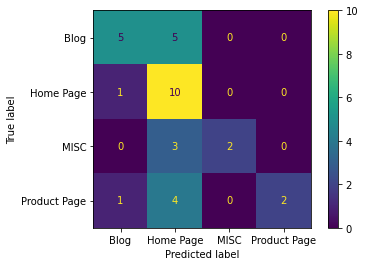

In [524]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred) # with more data until row 262
plt.show()

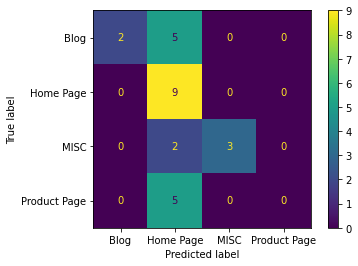

In [343]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred) # before (with less data) until row 222
plt.show()

Same model but removing stop words:

In [525]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3), stop_words={'english'})
X_train_transformed = vectorizer.fit_transform(X_train[TEXT])
X_test_transformed = vectorizer.transform(X_test[TEXT])
X_train_transformed.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.06539758, 0.06539758,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [526]:
lr = LogisticRegression(max_iter=3000)
lr.fit(X_train_transformed, y_train)

LogisticRegression(max_iter=3000)

In [527]:
y_pred = lr.predict(X_test_transformed)

In [528]:
print(f'Accuracy predicting always majority class: {sum(y_test == majority_class) / len(y_test):.4f}')
print(f'Accuracy with model: {sum(y_pred == y_test) / len(y_test):.4f}')

Accuracy predicting always majority class: 0.3333
Accuracy with model: 0.5758


In [529]:
FEATURES = 5
coef_importances = np.argsort(lr.coef_, axis=1)
for i, class_ in enumerate(coef_importances[:, :FEATURES]):
    print(f'Class "{lr.classes_[i]}" - {FEATURES} most important features: '
          f'{vectorizer.get_feature_names_out()[class_]}')

Class "Blog" - 5 most important features: ['guest' 'our' 'and' 'we' 'guest post']
Class "Home Page" - 5 most important features: ['keyword' 'guest' 'post' 'your' 'essay']
Class "MISC" - 5 most important features: ['search' 'what' 'content' 'essay' 'marketing']
Class "Product Page" - 5 most important features: ['guest' 'post' 'be' 'first' 'marketing']


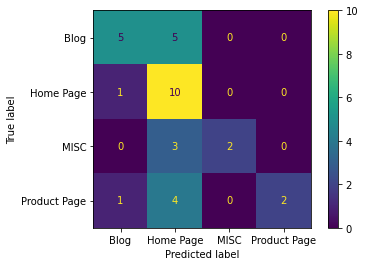

In [530]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred) # with more data until row 262
plt.show()

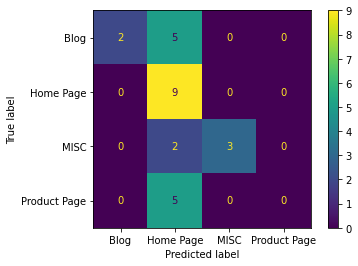

In [349]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred) # before (with less data) until row 222
plt.show()

# Zero-shot + fine-tuning model

In [353]:
classifier = pipeline("zero-shot-classification", model='facebook/bart-large-mnli')

In [356]:
df_reduced

,text,label
2,write for us. we allow you an endless opportun...,MISC
3,write for us. if you’ve got an idea that will ...,MISC
4,faqs for some new features available in the be...,Blog
7,the web credibility project. our research in w...,Home Page
8,model djs for retail. djpeoples is the nation’...,MISC
...,...,...
163,how to do keyword research for seo: a beginner...,Blog
164,keyword research 101: how to discover new keyw...,Blog
165,8 modern tips for marketing to millennials. th...,Blog
166,6 underutilized lead sources your agency shoul...,Blog


In [358]:
df_reduced[TARGET].value_counts()

Home Page       43
Blog            33
Product Page    28
MISC            24
Name: label, dtype: int64

In [367]:
for j, text in enumerate(df_reduced[TEXT].values):
  candidate_labels = ['home page', 'blog page', 'product page']

  output = classifier(text, candidate_labels)

  if output['scores'][0] < 0.4:
    predicted_label = 'MISC'
  else:
    predicted_label = output['labels'][0]

  print(f'Article {j} - True label: {y[j]} - Predicted label: {predicted_label}')

  if predicted_label == y[j]:
    print('Correctly predicted!')
  else:
    print('Failed to predict!')

  for i, label in enumerate(output['labels']):
    score = output['scores'][i]
    print(f"{score:.2%}: {label}")

  print('')

Article 0 - True label: MISC - Predicted label: blog page
Failed to predict!
42.13%: blog page
30.02%: product page
27.86%: home page

Article 1 - True label: MISC - Predicted label: MISC
Correctly predicted!
34.19%: home page
33.66%: blog page
32.15%: product page

Article 2 - True label: Blog - Predicted label: MISC
Failed to predict!
35.71%: blog page
35.27%: home page
29.02%: product page

Article 3 - True label: Home Page - Predicted label: MISC
Failed to predict!
34.51%: product page
34.46%: blog page
31.03%: home page

Article 4 - True label: MISC - Predicted label: product page
Failed to predict!
46.78%: product page
27.26%: home page
25.95%: blog page

Article 5 - True label: Home Page - Predicted label: MISC
Failed to predict!
37.95%: blog page
33.26%: product page
28.79%: home page

Article 6 - True label: MISC - Predicted label: blog page
Failed to predict!
49.88%: blog page
35.09%: home page
15.03%: product page

Article 7 - True label: MISC - Predicted label: blog page
Fa

KeyboardInterrupt: ignored

In [458]:
y

0           MISC
1           MISC
2           Blog
3      Home Page
4           MISC
         ...    
123         Blog
124         Blog
125         Blog
126         Blog
127         Blog
Name: label, Length: 128, dtype: object

In [463]:
y.reset_index(drop=True, inplace=True)
y_copy = y.copy()
y_copy.replace({'Home Page': 'homepage', 'Blog': 'blog', 'Product Page': 'product page'}, inplace=True)

In [464]:
y_copy

0          MISC
1          MISC
2          blog
3      homepage
4          MISC
         ...   
123        blog
124        blog
125        blog
126        blog
127        blog
Name: label, Length: 128, dtype: object

In [465]:
y_copy.value_counts()

homepage        43
blog            33
product page    28
MISC            24
Name: label, dtype: int64

In [457]:
MISC_THRESHOLD = 0.4

for j, text in enumerate(df_reduced[TEXT].values):
  candidate_labels = ['homepage', 'blog', 'product page']

  output = classifier(text, candidate_labels)

  if output['scores'][0] < MISC_THRESHOLD:
    predicted_label = 'MISC'
  else:
    predicted_label = output['labels'][0]

  print(f'Article {j} - True label: {y_copy[j]} - Predicted label: {predicted_label}')

  if predicted_label == y_copy[j]:
    print('Correctly predicted!')
  else:
    print('Failed to predict!')

  for i, label in enumerate(output['labels']):
    score = output['scores'][i]
    print(f"{score:.2%}: {label}")

  print('')

Article 0 - True label: MISC - Predicted label: blog
Failed to predict!
43.46%: blog
29.57%: homepage
26.97%: product page

Article 1 - True label: MISC - Predicted label: MISC
Correctly predicted!
36.71%: homepage
33.24%: product page
30.06%: blog

Article 2 - True label: blog - Predicted label: MISC
Failed to predict!
37.63%: homepage
31.26%: blog
31.11%: product page

Article 3 - True label: homepage - Predicted label: MISC
Failed to predict!
36.59%: product page
35.59%: blog
27.82%: homepage

Article 4 - True label: MISC - Predicted label: product page
Failed to predict!
45.07%: product page
27.98%: homepage
26.95%: blog

Article 5 - True label: homepage - Predicted label: MISC
Failed to predict!
36.39%: blog
33.01%: homepage
30.61%: product page

Article 6 - True label: MISC - Predicted label: blog
Failed to predict!
57.62%: blog
27.43%: homepage
14.95%: product page

Article 7 - True label: MISC - Predicted label: blog
Failed to predict!
65.44%: blog
23.85%: homepage
10.71%: prod

KeyboardInterrupt: ignored

# Main pipeline (Newspaper library)

In [ ]:
# url = "https://elgourmeturbano.blogspot.com/2010/12/el-secreto-de-un-buen-capuchino.html"

# toi_article = Article(url, language="es")
# toi_article.download()
# toi_article.parse()
# toi_article.nlp()

# article_and_summary = toi_article.title + '. ' + toi_article.summary

# candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

# output = classifier(article_and_summary, candidate_labels)
# for i, label in enumerate(output['labels']):
#   print(f"{output['scores'][i]:.2%}: {label}")

40.32%: blog
25.72%: webinar
13.77%: contingency
13.24%: press release
6.96%: white paper


In [ ]:
url = "https://ethereum.org/en/whitepaper/"

toi_article = Article(url, language="en")
# toi_article.download()
# toi_article.parse()
# toi_article.nlp()
toi_article.html

'<!DOCTYPE html><html lang="en"><head><meta charSet="utf-8"/><meta http-equiv="x-ua-compatible" content="ie=edge"/><meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no"/><meta name="generator" content="Gatsby 4.21.1"/><meta data-react-helmet="true" property="og:locale" content="en"/><meta data-react-helmet="true" property="og:locale:alternate" content="ar"/><meta data-react-helmet="true" property="og:locale:alternate" content="az"/><meta data-react-helmet="true" property="og:locale:alternate" content="bg"/><meta data-react-helmet="true" property="og:locale:alternate" content="bn"/><meta data-react-helmet="true" property="og:locale:alternate" content="ca"/><meta data-react-helmet="true" property="og:locale:alternate" content="cs"/><meta data-react-helmet="true" property="og:locale:alternate" content="da"/><meta data-react-helmet="true" property="og:locale:alternate" content="de"/><meta data-react-helmet="true" property="og:locale:alternate" content="el"/>

In [ ]:
url = "https://ethereum.org/en/whitepaper/"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.text

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

23.95%: contingency
22.75%: white paper
20.09%: webinar
16.94%: press release
16.27%: blog


In [ ]:
toi_article.summary

'Para aprender sobre los últimos desarrollos de Ethereum, y cómo se hacen los cambios en el protocolo, recomendamos esta guía.\nAquí puedes consultar una entrada del blog de Vitalik Buterin, el fundador de Ethereum, en Prehistorial de Ethereum.\nUniversalidad: una parte fundamental de la filosofía de diseño de Ethereum es que Ethereum no tiene "funciones".fn.\nEsto es así puesto que, aunque se usan en Ethereum e incluso si Ethereum no requiere ciertas funciones, estas funciones siguen siendo utilizables también en otros protocolos.\nAl igual que Bitcoin, Ethereum sufre del defecto de que cada transacción tiene que ser procesada por cada nodo de la red.'

In [ ]:
url = "https://indigenousfoundations.arts.ubc.ca/the_white_paper_1969/"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

75.44%: white paper
10.87%: contingency
4.99%: blog
4.50%: webinar
4.20%: press release


In [ ]:
toi_article.summary

'In the Canadian legislature, a policy paper is called a white paper.\nThe 1969 white paper proposing the abolition of the Indian Act was formally called the Statement of the Government of Canada on Indian Policy.\nIn June 1969, Ottawa, in answer to the consultations, produced their white paper proposing to dismantle Indian Affairs.\nRose CharlieRose Charlie describing her reaction to the White Paper proposal in 1969.\nIndian Position Paper, or “Brown Paper,” of 1970 rejected the 1969 white paper’s proposals and asserted that Aboriginal peoples continued to hold Aboriginal title to the land.'

# Testing

In [ ]:
sequence = "Who are you voting for in 2020?"
candidate_labels = ['politics', 'public health', 'economics', 'president', 'voting', 'elections']
output = classifier(sequence, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

34.23%: politics
32.50%: voting
30.31%: elections
1.99%: president
0.51%: economics
0.45%: public health


In [ ]:
sequence = "Is River Plate the best team?"
candidate_labels = ['politics', 'football', 'economics', 'game', 'sport', 'elections']
output = classifier(sequence, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

70.58%: sport
18.70%: game
6.64%: football
1.54%: economics
1.38%: politics
1.16%: elections


In [ ]:
sequence = "My name is Hernan and I teach data science at ITC"
candidate_labels = ['education', 'technology', 'personal life', 'data science', 'Hernan', 'presentation', 'introduction', 'who am i', 'babies', 'forest']

output = classifier(sequence, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

42.51%: Hernan
32.59%: data science
17.88%: who am i
3.49%: technology
1.48%: introduction
0.75%: education
0.49%: forest
0.44%: presentation
0.26%: personal life
0.12%: babies


In [ ]:
# Random blog from Shopify
sequence = "Ah, the thrill of the hunt. If you live for the high of scoring a vintage dress at your local thrift store and bragging about how little you paid, selling vintage clothing "\
"online might be right for you. Having an eye for sourcing and curating vintage is a skill—and it could have benefits beyond your unique wardrobe.  "\
"Fast fashion outlets scramble to mimic vintage-style runway trends, pumping out $20 versions of those corduroy overalls you loved in the ’90s. But nothing will replace the real deal. "\
"Vintage shoppers rely on store owners to do the tedious sifting, curating a painless browsing experience of only the best items, in the best condition. And with rapidly shifting consumer "\
"consciousness about where clothes come from, selling vintage clothing is a sustainable business opportunity in a growing market."\
" This guide will walk you through each step in building your own brand and selling vintage clothes online: where to find vintage goods, photography tips, pricing strategies, and more. "
"Plus, successful vintage sellers pass on their tips on sourcing and success."

candidate_labels = ['blog', 'events', 'webinar', 'press release', 'white paper']

output = classifier(sequence, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

30.05%: blog
22.33%: webinar
21.28%: events
17.73%: press release
8.61%: white paper


In [ ]:
# Bitcoin's white paper abstract
sequence2 = "A purely peer-to-peer version of electronic cash would allow online payments "\
"to be sent directly from one party to another without going through a "\
"financial institution. Digital signatures provide part of the solution, but the main "\
"benefits are lost if a trusted third party is still required to prevent double-spending. "\
"We propose a solution to the double-spending problem using a peer-to-peer network. "\
"The network timestamps transactions by hashing them into an ongoing chain of "\
"hash-based proof-of-work, forming a record that cannot be changed without redoing "\
"the proof-of-work. The longest chain not only serves as proof of the sequence of "\
"events witnessed, but proof that it came from the largest pool of CPU power. As "\
"long as a majority of CPU power is controlled by nodes that are not cooperating to "\
"attack the network, they'll generate the longest chain and outpace attackers. The "\
"network itself requires minimal structure. Messages are broadcast on a best effort "\
"basis, and nodes can leave and rejoin the network at will, accepting the longest "\
"proof-of-work chain as proof of what happened while they were gone."

output = classifier(sequence2, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

57.49%: events
13.44%: blog
10.40%: press release
9.90%: webinar
8.77%: white paper


In [ ]:
# Bitcoin's white paper introduction
sequence3 = "Commerce on the Internet has come to rely almost exclusively on financial institutions serving as "\
"trusted third parties to process electronic payments. While the system works well enough for "\
"most transactions, it still suffers from the inherent weaknesses of the trust based model."\
"Completely non-reversible transactions are not really possible, since financial institutions cannot "\
"avoid mediating disputes. The cost of mediation increases transaction costs, limiting the "\
"minimum practical transaction size and cutting off the possibility for small casual transactions, "\
"and there is a broader cost in the loss of ability to make non-reversible payments for nonreversible services. With the possibility of reversal, the need for trust spreads. Merchants must "\
"be wary of their customers, hassling them for more information than they would otherwise need. "\
"A certain percentage of fraud is accepted as unavoidable. These costs and payment uncertainties "\
"can be avoided in person by using physical currency, but no mechanism exists to make payments "\
"over a communications channel without a trusted party. "\
"What is needed is an electronic payment system based on cryptographic proof instead of trust, "\
"allowing any two willing parties to transact directly with each other without the need for a trusted "\
"third party. Transactions that are computationally impractical to reverse would protect sellers "\
"from fraud, and routine escrow mechanisms could easily be implemented to protect buyers. In "\
"this paper, we propose a solution to the double-spending problem using a peer-to-peer distributed "\
"timestamp server to generate computational proof of the chronological order of transactions. The "\
"system is secure as long as honest nodes collectively control more CPU power than any "\
"cooperating group of attacker nodes."

output = classifier(sequence3, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

32.09%: events
23.99%: white paper
20.34%: blog
12.25%: webinar
11.33%: press release


In [ ]:
# 3pl central webinar
sequence4 = "Tips for Preparing Your Warehouse for Peak Season 2022 "\
"On-Demand "\
"Is your warehouse ready for peak season? With all the challenges warehouses have faced this past year, it is more important than ever to prepare early for success. "\
"In this webinar, you’ll learn about the actions you can take now to thrive this peak season. Topics will include: "\
"Optimizing Processes – How to best tackle supply chain challenges "\
"Fulfillment Strategies – What you need to know about B2B and ecommerce "\
"Small Parcel Shipping – How to diversify carrier strategies and negotiate better pricing "\
"Tools and Technology – What automation you can utilize now to streamline processes "

output = classifier(sequence4, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

89.82%: webinar
3.35%: events
3.16%: press release
2.62%: blog
1.05%: white paper


In [ ]:
# 3pl central webinar (changing word 'webinar' in the text for 'event' manually)
sequence4 = "Tips for Preparing Your Warehouse for Peak Season 2022 "\
"On-Demand "\
"Is your warehouse ready for peak season? With all the challenges warehouses have faced this past year, it is more important than ever to prepare early for success. "\
"In this event, you’ll learn about the actions you can take now to thrive this peak season. Topics will include: "\
"Optimizing Processes – How to best tackle supply chain challenges "\
"Fulfillment Strategies – What you need to know about B2B and ecommerce "\
"Small Parcel Shipping – How to diversify carrier strategies and negotiate better pricing "\
"Tools and Technology – What automation you can utilize now to streamline processes "

output = classifier(sequence4, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

77.34%: events
7.79%: webinar
6.13%: blog
6.01%: press release
2.74%: white paper


In [ ]:
# 3pl central webinar (removing word 'webinar' in the text)
sequence4 = "Tips for Preparing Your Warehouse for Peak Season 2022 "\
"On-Demand "\
"Is your warehouse ready for peak season? With all the challenges warehouses have faced this past year, it is more important than ever to prepare early for success. "\
"You’ll learn about the actions you can take now to thrive this peak season. Topics will include: "\
"Optimizing Processes – How to best tackle supply chain challenges "\
"Fulfillment Strategies – What you need to know about B2B and ecommerce "\
"Small Parcel Shipping – How to diversify carrier strategies and negotiate better pricing "\
"Tools and Technology – What automation you can utilize now to streamline processes "

output = classifier(sequence4, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

26.76%: webinar
23.76%: events
23.74%: blog
16.40%: press release
9.35%: white paper


In [ ]:
# Full press release https://www.state.gov/joint-statement-on-venezuela-negotiations-2/

sequence5 = "The following statement was released by Secretary of State Antony J. Blinken, the EU High Representative for Foreign Affairs and Security Policy Josep Borrell Fontelles, the Canadian Minister of Foreign Affairs the Honourable Mélanie Joly, and the United Kingdom Secretary of State for Foreign, Commonwealth and Development Affairs James Cleverly. "\
"We welcome the decision announced today by Venezuelan negotiators to restart the dialogue process in Mexico City.  We urge the parties to engage in good faith toward a comprehensive agreement leading to free and fair elections in 2024, the restoration of democratic institutions, and an end to the humanitarian crisis in Venezuela. "\
"We welcome the Mesa Social humanitarian agreement and the willingness of all parties to pursue joint initiatives that will benefit the Venezuelan people and help address their dire humanitarian needs.  This agreement provides the template for how further progress can be secured.  We are grateful for the work of the United Nations towards this goal. "\
"We believe that participation in the negotiations should be inclusive, diverse, and representative of the Venezuelan population to ensure that an agreement is durable and long-lasting. "\
"We continue to call for the unconditional release of all those unjustly detained for political reasons, the independence of the electoral process and judicial institutions, freedom of expression including for members of the press, and respect for human rights. "\
"We remain committed to supporting the return of democracy in Venezuela and the efforts by Venezuelans to reach their democratic aspirations.  In this context, we underline the need for the immediate implementation of the recommendations of the 2021 EU Electoral Observation Mission to Venezuela aimed at improving future electoral processes in line with international commitments on democratic elections subscribed by Venezuela. "\
"We will continue to work with our international partners to address the urgent needs of all Venezuelans inside and outside their country. "\
"We are grateful to Norway for their steadfast dedication in facilitating this process, to Mexico for hosting the negotiations, and to Venezuela’s democratic actors whose commitment to finding a negotiated solution to the crisis has been resolute. "\
"We reiterate our willingness to review sanctions policies if the regime makes meaningful progress in the announced talks to alleviate the suffering of the Venezuelan people and bring them closer to a restoration of democracy. "

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(sequence5, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

46.06%: event
33.46%: press release
8.11%: blog
7.64%: webinar
4.73%: white paper


In [ ]:
# Full press release with header included https://www.state.gov/joint-statement-on-venezuela-negotiations-2/

sequence6 = "Joint Statement on Venezuela Negotiations "\
"MEDIA NOTE "\
"OFFICE OF THE SPOKESPERSON "\
"The following statement was released by Secretary of State Antony J. Blinken, the EU High Representative for Foreign Affairs and Security Policy Josep Borrell Fontelles, the Canadian Minister of Foreign Affairs the Honourable Mélanie Joly, and the United Kingdom Secretary of State for Foreign, Commonwealth and Development Affairs James Cleverly. "\
"We welcome the decision announced today by Venezuelan negotiators to restart the dialogue process in Mexico City.  We urge the parties to engage in good faith toward a comprehensive agreement leading to free and fair elections in 2024, the restoration of democratic institutions, and an end to the humanitarian crisis in Venezuela. "\
"We welcome the Mesa Social humanitarian agreement and the willingness of all parties to pursue joint initiatives that will benefit the Venezuelan people and help address their dire humanitarian needs.  This agreement provides the template for how further progress can be secured.  We are grateful for the work of the United Nations towards this goal. "\
"We believe that participation in the negotiations should be inclusive, diverse, and representative of the Venezuelan population to ensure that an agreement is durable and long-lasting. "\
"We continue to call for the unconditional release of all those unjustly detained for political reasons, the independence of the electoral process and judicial institutions, freedom of expression including for members of the press, and respect for human rights. "\
"We remain committed to supporting the return of democracy in Venezuela and the efforts by Venezuelans to reach their democratic aspirations.  In this context, we underline the need for the immediate implementation of the recommendations of the 2021 EU Electoral Observation Mission to Venezuela aimed at improving future electoral processes in line with international commitments on democratic elections subscribed by Venezuela. "\
"We will continue to work with our international partners to address the urgent needs of all Venezuelans inside and outside their country. "\
"We are grateful to Norway for their steadfast dedication in facilitating this process, to Mexico for hosting the negotiations, and to Venezuela’s democratic actors whose commitment to finding a negotiated solution to the crisis has been resolute. "\
"We reiterate our willingness to review sanctions policies if the regime makes meaningful progress in the announced talks to alleviate the suffering of the Venezuelan people and bring them closer to a restoration of democracy. "


candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(sequence6, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

48.10%: press release
33.35%: event
7.21%: blog
6.15%: webinar
5.20%: white paper


In [ ]:
# Full press release (adding 'Press release' manually at the beginning) https://www.state.gov/joint-statement-on-venezuela-negotiations-2/

sequence5 = "Press release: The following statement was released by Secretary of State Antony J. Blinken, the EU High Representative for Foreign Affairs and Security Policy Josep Borrell Fontelles, the Canadian Minister of Foreign Affairs the Honourable Mélanie Joly, and the United Kingdom Secretary of State for Foreign, Commonwealth and Development Affairs James Cleverly. "\
"We welcome the decision announced today by Venezuelan negotiators to restart the dialogue process in Mexico City.  We urge the parties to engage in good faith toward a comprehensive agreement leading to free and fair elections in 2024, the restoration of democratic institutions, and an end to the humanitarian crisis in Venezuela. "\
"We welcome the Mesa Social humanitarian agreement and the willingness of all parties to pursue joint initiatives that will benefit the Venezuelan people and help address their dire humanitarian needs.  This agreement provides the template for how further progress can be secured.  We are grateful for the work of the United Nations towards this goal. "\
"We believe that participation in the negotiations should be inclusive, diverse, and representative of the Venezuelan population to ensure that an agreement is durable and long-lasting. "\
"We continue to call for the unconditional release of all those unjustly detained for political reasons, the independence of the electoral process and judicial institutions, freedom of expression including for members of the press, and respect for human rights. "\
"We remain committed to supporting the return of democracy in Venezuela and the efforts by Venezuelans to reach their democratic aspirations.  In this context, we underline the need for the immediate implementation of the recommendations of the 2021 EU Electoral Observation Mission to Venezuela aimed at improving future electoral processes in line with international commitments on democratic elections subscribed by Venezuela. "\
"We will continue to work with our international partners to address the urgent needs of all Venezuelans inside and outside their country. "\
"We are grateful to Norway for their steadfast dedication in facilitating this process, to Mexico for hosting the negotiations, and to Venezuela’s democratic actors whose commitment to finding a negotiated solution to the crisis has been resolute. "\
"We reiterate our willingness to review sanctions policies if the regime makes meaningful progress in the announced talks to alleviate the suffering of the Venezuelan people and bring them closer to a restoration of democracy. "

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(sequence5, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

57.86%: press release
28.00%: event
5.31%: blog
4.74%: webinar
4.10%: white paper


### Webscraper

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

# url = "https://smallbusiness.chron.com/extract-text-pages-43782.html"
url = "https://www.shopify.com/blog/211022217-sell-vintage-clothing-online"

html = urlopen(url).read()
soup = BeautifulSoup(html, features="html.parser")

# kill all script and style elements
for script in soup(["script", "style"]):
    script.extract()    # rip it out

# get text
text = soup.get_text()

# break into lines and remove leading and trailing space on each
lines = (line.strip() for line in text.splitlines())
# break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
# drop blank lines
text = '\n'.join(chunk for chunk in chunks if chunk)

print(text)

How to Sell Vintage Clothing Online: The Ultimate Guide (2023)
Email address
Password
Store name
Your store name
Create your store
Build your dream business for $1/month
Start your free trial, then enjoy 3 months of Shopify for $1/month when you sign up for a monthly Basic or Starter plan.
Sign up for a free trial
Select a monthly Basic or Starter plan
$1/month pricing will be applied at checkout
Add products, launch your store, and start selling!
Start a free trial and enjoy 3 months of Shopify for $1/month on select plans. Sign up now
Skip to Content
Shopify
Start
Start your businessBranding
Look professional and help customers connect with your businessBusiness name generatorLogo makerOnline presence
Find a domain, explore stock images, and amplify your brandDomain nameStock photographyStore set up
Use Shopify’s powerful features to start sellingProducts to sellWebsite BuilderStore themesSell
Sell everywhereOnline store
Sell online with an ecommerce websiteOverviewExamplesThemesPoin

In [ ]:
text

"How to Sell Vintage Clothing Online: The Ultimate Guide (2023)\nEmail address\nPassword\nStore name\nYour store name\nCreate your store\nBuild your dream business for $1/month\nStart your free trial, then enjoy 3 months of Shopify for $1/month when you sign up for a monthly Basic or Starter plan.\nSign up for a free trial\nSelect a monthly Basic or Starter plan\n$1/month pricing will be applied at checkout\nAdd products, launch your store, and start selling!\nStart a free trial and enjoy 3 months of Shopify for $1/month on select plans. Sign up now\nSkip to Content\nShopify\nStart\nStart your businessBranding\nLook professional and help customers connect with your businessBusiness name generatorLogo makerOnline presence\nFind a domain, explore stock images, and amplify your brandDomain nameStock photographyStore set up\nUse Shopify’s powerful features to start sellingProducts to sellWebsite BuilderStore themesSell\nSell everywhereOnline store\nSell online with an ecommerce websiteOver

In [ ]:
output = classifier(text, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

23.65%: event
23.30%: blog
19.92%: press release
18.79%: webinar
14.34%: white paper


# Trafilatura library

Trafilatura is used to get only the main text of a website, so all non-important text is ignored.

In [ ]:
# Random Shopify blog
downloaded = trafilatura.fetch_url('https://www.shopify.com/blog/211022217-sell-vintage-clothing-online')
text = trafilatura.extract(downloaded) # outputs main content and comments as plain text ...

output = classifier(text, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

28.12%: event
27.66%: webinar
18.90%: press release
15.47%: white paper
9.84%: blog


In [ ]:
text

"Ah, the thrill of the hunt. If you live for the high of scoring a vintage dress at your local thrift store and bragging about how little you paid, selling vintage clothing online might be right for you. Having an eye for sourcing and curating vintage is a skill—and it could have benefits beyond your unique wardrobe.\nFast fashion outlets scramble to mimic vintage-style runway trends, pumping out $20 versions of those corduroy overalls you loved in the ’90s. But nothing will replace the real deal.\nWith rapidly shifting consumer consciousness about where clothes come from, selling vintage clothing is a sustainable business opportunity with a growing market.\nVintage shoppers rely on store owners to do the tedious sifting, curating a painless browsing experience of only the best items, in the best condition. And with rapidly shifting consumer consciousness about where clothes come from, selling vintage clothing is a sustainable business opportunity in a growing market.\nThis guide will 

In [ ]:
# Random Press release (same as before)
downloaded = trafilatura.fetch_url('https://www.state.gov/joint-statement-on-venezuela-negotiations-2/')
text = trafilatura.extract(downloaded) # outputs main content and comments as plain text ...

output = classifier(text, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

41.33%: event
31.42%: press release
11.05%: blog
8.77%: webinar
7.43%: white paper


In [ ]:
text

'The following statement was released by Secretary of State Antony J. Blinken, the EU High Representative for Foreign Affairs and Security Policy Josep Borrell Fontelles, the Canadian Minister of Foreign Affairs the Honourable Mélanie Joly, and the United Kingdom Secretary of State for Foreign, Commonwealth and Development Affairs James Cleverly.\nWe welcome the decision announced today by Venezuelan negotiators to restart the dialogue process in Mexico City. We urge the parties to engage in good faith toward a comprehensive agreement leading to free and fair elections in 2024, the restoration of democratic institutions, and an end to the humanitarian crisis in Venezuela.\nWe welcome the Mesa Social humanitarian agreement and the willingness of all parties to pursue joint initiatives that will benefit the Venezuelan people and help address their dire humanitarian needs. This agreement provides the template for how further progress can be secured. We are grateful for the work of the Uni

In [ ]:
text

In [ ]:
# Ethereum's whitepaper
downloaded = trafilatura.fetch_url("https://ethereum.org/en/whitepaper/")
text = trafilatura.extract(downloaded) # outputs main content and comments as plain text ...

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(text, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

31.88%: event
19.57%: white paper
18.47%: webinar
15.66%: press release
14.43%: blog


In [ ]:
text

'Page last updated: November 25, 2022\nEthereum Whitepaper\nThis introductory paper was originally published in 2014 by Vitalik Buterin, the founder of Ethereum, before the project\'s launch in 2015. It\'s worth noting that Ethereum, like many community-driven, open-source software projects, has evolved since its initial inception.\nWhile several years old, we maintain this paper because it continues to serve as a useful reference and an accurate representation of Ethereum and its vision. To learn about the latest developments of Ethereum, and how changes to the protocol are made, we recommend this guide.\nResearchers and academics seeking a historical or canonical version of the whitepaper [from December 2014] should use this PDF.\nA Next-Generation Smart Contract and Decentralized Application Platform\nSatoshi Nakamoto\'s development of Bitcoin in 2009 has often been hailed as a radical development in money and currency, being the first example of a digital asset which simultaneously

In [ ]:
# Ethereum's whitepaper
downloaded = trafilatura.fetch_url("https://ethereum.org/en/whitepaper/")
text = trafilatura.extract(downloaded) # outputs main content and comments as plain text ...

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(text, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

In [ ]:
# Article that can't be read with Newspaper library
url = "https://learndigital.withgoogle.com/digitalgarage/f2f/events/writing-for-social-media?date=1669822200000"

downloaded = trafilatura.fetch_url(url)
text = trafilatura.extract(downloaded) # outputs main content and comments as plain text ...

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(text, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

45.91%: webinar
36.65%: event
11.40%: blog
3.33%: press release
2.71%: white paper


In [ ]:
downloaded

'<!doctype html>\n<html\n  lang="en-GB"\n  itemscope itemtype="http://schema.org/Organization"\n  \n  \n>\n  <head>\n    <base href="https://learndigital.withgoogle.com/digitalgarage/">\n    <meta charset="utf-8" />\n    <link rel="preconnect" href="https://fonts.gstatic.com">\n    <link rel="preconnect" href="https://www.gstatic.com">\n    <link rel="preload" href="/static/digital-workshop/assets/imgs/homepage/img_digital-workshop_hero_xs.webp" as="image" media="(max-width: 599px)">\n\n    <meta name="viewport" content="width=device-width,minimal-ui,initial-scale=1.0" />\n    \n      <meta name="description" content="Access free live Google webinars, workshops, and trainings designed to help grow your business or expand your career skills. Start learning today." />\n    \n    <meta property="og:description" content="Access free live Google webinars, workshops, and trainings designed to help grow your business or expand your career skills. Start learning today." />\n    <meta property=

In [ ]:
text

'Free Webinars, Workshops & Trainings - Google Digital Garage - Google Digital Garage'

In [ ]:
downloaded = trafilatura.fetch_url('https://github.blog/2019-03-29-leader-spotlight-erin-spiceland/')
downloaded

'<!doctype html>\n<html lang="en-US">\n<head>\n\t<meta charset="UTF-8">\n\t<meta name="viewport" content="width=device-width, initial-scale=1">\n\t<link rel="profile" href="https://gmpg.org/xfn/11">\n\t<link rel="icon" type="image/x-icon" href="https://github.githubassets.com/favicon.ico">\n\t<meta name=\'robots\' content=\'index, follow, max-image-preview:large, max-snippet:-1, max-video-preview:-1\' />\n\n\t<!-- This site is optimized with the Yoast SEO Premium plugin v17.0 (Yoast SEO v19.6.1) - https://yoast.com/wordpress/plugins/seo/ -->\n\t<title>Leader spotlight: Erin Spiceland | The GitHub Blog</title>\n\t<meta name="description" content="We’re spending Women’s History Month with women leaders who are making history every day in the tech community." />\n\t<link rel="canonical" href="https://github.blog/2019-03-29-leader-spotlight-erin-spiceland/" />\n\t<meta property="og:locale" content="en_US" />\n\t<meta property="og:type" content="article" />\n\t<meta property="og:title" cont

# Newspaper library

In [ ]:
# Ethereum's whitepaper
url = "https://ethereum.org/en/whitepaper/"

#For different language newspaper refer above table
toi_article = Article(url, language="en") # en for English
 
#To download the article
toi_article.download()
 
#To parse the article
toi_article.parse()
 
#To perform natural language processing ie..nlp
toi_article.nlp()
 
#To extract title
print("Article's Title:")
print(toi_article.title)
print("n")
 
#To extract text
print("Article's Text:")
print(toi_article.text)
print("n")
 
#To extract summary
print("Article's Summary:")
print(toi_article.summary)
print("n")
 
#To extract keywords
print("Article's Keywords:")
print(toi_article.keywords)

Article's Title:
Ethereum Whitepaper
n
Article's Text:
Page last updated: November 25, 2022

Ethereum Whitepaper

This introductory paper was originally published in 2014 by Vitalik Buterin, the founder of Ethereum, before the project's launch in 2015. It's worth noting that Ethereum, like many community-driven, open-source software projects, has evolved since its initial inception.

While several years old, we maintain this paper because it continues to serve as a useful reference and an accurate representation of Ethereum and its vision. To learn about the latest developments of Ethereum, and how changes to the protocol are made, we recommend this guide.

Researchers and academics seeking a historical or canonical version of the whitepaper [from December 2014] should use this PDF.

A Next-Generation Smart Contract and Decentralized Application Platform

Satoshi Nakamoto's development of Bitcoin in 2009 has often been hailed as a radical development in money and currency, being the fi

In [ ]:
# Random Press release (same as before)
url = 'https://www.state.gov/joint-statement-on-venezuela-negotiations-2/'

#For different language newspaper refer above table
toi_article = Article(url, language="en") # en for English
 
#To download the article
toi_article.download()
 
#To parse the article
toi_article.parse()
 
#To perform natural language processing ie..nlp
toi_article.nlp()
 
#To extract title
print("Article's Title:")
print(toi_article.title)
print("n")
 
#To extract text
print("Article's Text:")
print(toi_article.text)
print("n")
 
#To extract summary
print("Article's Summary:")
print(toi_article.summary)
print("n")
 
#To extract keywords
print("Article's Keywords:")
print(toi_article.keywords)

Article's Title:
Joint Statement on Venezuela Negotiations
n
Article's Text:
The following statement was released by Secretary of State Antony J. Blinken, the EU High Representative for Foreign Affairs and Security Policy Josep Borrell Fontelles, the Canadian Minister of Foreign Affairs the Honourable Mélanie Joly, and the United Kingdom Secretary of State for Foreign, Commonwealth and Development Affairs James Cleverly.

We welcome the decision announced today by Venezuelan negotiators to restart the dialogue process in Mexico City. We urge the parties to engage in good faith toward a comprehensive agreement leading to free and fair elections in 2024, the restoration of democratic institutions, and an end to the humanitarian crisis in Venezuela.

We welcome the Mesa Social humanitarian agreement and the willingness of all parties to pursue joint initiatives that will benefit the Venezuelan people and help address their dire humanitarian needs. This agreement provides the template for 

In [ ]:
joined_keywords = ', '.join(toi_article.keywords)
joined_keywords

'agreement, affairs, willingness, statement, work, process, foreign, democratic, humanitarian, electoral, joint, venezuela, negotiations, venezuelan'

In [ ]:
candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(joined_keywords, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

40.33%: event
22.25%: blog
16.97%: press release
11.16%: webinar
9.29%: white paper


In [ ]:
toi_article.title

'Joint Statement on Venezuela Negotiations'

In [ ]:
joined_title_and_keywords = toi_article.title + ', ' + joined_keywords
joined_title_and_keywords

'Joint Statement on Venezuela Negotiations, agreement, affairs, willingness, statement, work, process, foreign, democratic, humanitarian, electoral, joint, venezuela, negotiations, venezuelan'

In [ ]:
output = classifier(joined_title_and_keywords, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

59.61%: event
16.45%: press release
10.30%: blog
7.04%: white paper
6.59%: webinar


In [ ]:
toi_article.summary

'The following statement was released by Secretary of State Antony J. Blinken, the EU High Representative for Foreign Affairs and Security Policy Josep Borrell Fontelles, the Canadian Minister of Foreign Affairs the Honourable Mélanie Joly, and the United Kingdom Secretary of State for Foreign, Commonwealth and Development Affairs James Cleverly.\nWe welcome the decision announced today by Venezuelan negotiators to restart the dialogue process in Mexico City.\nWe welcome the Mesa Social humanitarian agreement and the willingness of all parties to pursue joint initiatives that will benefit the Venezuelan people and help address their dire humanitarian needs.\nWe believe that participation in the negotiations should be inclusive, diverse, and representative of the Venezuelan population to ensure that an agreement is durable and long-lasting.\nWe remain committed to supporting the return of democracy in Venezuela and the efforts by Venezuelans to reach their democratic aspirations.'

In [ ]:
toi_article.text

'The following statement was released by Secretary of State Antony J. Blinken, the EU High Representative for Foreign Affairs and Security Policy Josep Borrell Fontelles, the Canadian Minister of Foreign Affairs the Honourable Mélanie Joly, and the United Kingdom Secretary of State for Foreign, Commonwealth and Development Affairs James Cleverly.\n\nWe welcome the decision announced today by Venezuelan negotiators to restart the dialogue process in Mexico City. We urge the parties to engage in good faith toward a comprehensive agreement leading to free and fair elections in 2024, the restoration of democratic institutions, and an end to the humanitarian crisis in Venezuela.\n\nWe welcome the Mesa Social humanitarian agreement and the willingness of all parties to pursue joint initiatives that will benefit the Venezuelan people and help address their dire humanitarian needs. This agreement provides the template for how further progress can be secured. We are grateful for the work of the

In [ ]:
output = classifier(toi_article.summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

45.85%: press release
32.46%: event
7.95%: blog
7.81%: webinar
5.92%: white paper


In [ ]:
output = classifier(toi_article.text, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

40.83%: event
30.89%: press release
12.53%: blog
8.95%: webinar
6.79%: white paper


In [ ]:
article_and_summary = toi_article.title + '. ' + toi_article.summary
article_and_summary

'Joint Statement on Venezuela Negotiations. The following statement was released by Secretary of State Antony J. Blinken, the EU High Representative for Foreign Affairs and Security Policy Josep Borrell Fontelles, the Canadian Minister of Foreign Affairs the Honourable Mélanie Joly, and the United Kingdom Secretary of State for Foreign, Commonwealth and Development Affairs James Cleverly.\nWe welcome the decision announced today by Venezuelan negotiators to restart the dialogue process in Mexico City.\nWe welcome the Mesa Social humanitarian agreement and the willingness of all parties to pursue joint initiatives that will benefit the Venezuelan people and help address their dire humanitarian needs.\nWe believe that participation in the negotiations should be inclusive, diverse, and representative of the Venezuelan population to ensure that an agreement is durable and long-lasting.\nWe remain committed to supporting the return of democracy in Venezuela and the efforts by Venezuelans to

In [ ]:
output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

43.78%: press release
31.05%: event
8.61%: webinar
8.52%: white paper
8.05%: blog


In [ ]:
url = 'https://ethereum.org/en/whitepaper/'

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

50.39%: white paper
29.47%: event
10.34%: blog
5.34%: webinar
4.47%: press release


In [ ]:
# Occasion instead of event (ambiguous word)
url = 'https://ethereum.org/en/whitepaper/'

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'occasion', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

58.64%: white paper
17.91%: occasion
12.03%: blog
6.22%: webinar
5.20%: press release


In [ ]:
url = 'https://ethereum.org/en/whitepaper/'

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.summary # without title

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

50.51%: event
20.21%: blog
12.97%: webinar
9.69%: press release
6.63%: white paper


In [ ]:
# Another PRESS RELEASE
url = 'https://www.state.gov/secretary-blinkens-travel-to-romania/'

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

47.45%: event
18.81%: press release
15.48%: blog
9.54%: white paper
8.72%: webinar


In [ ]:
# Same PRESS RELEASE, without "event" (strong word, most articles predicted as such)
url = 'https://www.state.gov/secretary-blinkens-travel-to-romania/'

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

35.80%: press release
29.45%: blog
18.16%: white paper
16.59%: webinar


In [ ]:
toi_article.text

'Secretary of State Antony J. Blinken will travel to Bucharest, Romania November 28-30, where he will attend the NATO Foreign Ministers’ Meeting. The NATO Foreign Ministers’ Meeting will focus on Russia’s war against Ukraine, implementation of NATO’s new Strategic Concept, including challenges from the People’s Republic of China, energy security, protection of critical infrastructure, and NATO’s efforts to build capacity and strengthen resilience in Bosnia and Herzegovina, Georgia, and Moldova.\n\nWhile in Bucharest, Secretary Blinken and Romanian Prime Minister Nicolae Ciucă will tour the exhibit – We the People – 25 Years of Strategic Partnership – which celebrates key moments in the U.S.-Romania partnership since 1997.\n\nSecretary Blinken will have separate meetings with Romanian President Klaus Iohannis, Romanian Foreign Minister Bogdan Aurescu, and NATO Secretary General Jens Stoltenberg and will attend a working dinner with Ukrainian Foreign Minister Dmytro Kuleba.'

In [ ]:
toi_article.summary

'Secretary of State Antony J. Blinken will travel to Bucharest, Romania November 28-30, where he will attend the NATO Foreign Ministers’ Meeting.\nThe NATO Foreign Ministers’ Meeting will focus on Russia’s war against Ukraine, implementation of NATO’s new Strategic Concept, including challenges from the People’s Republic of China, energy security, protection of critical infrastructure, and NATO’s efforts to build capacity and strengthen resilience in Bosnia and Herzegovina, Georgia, and Moldova.\nWhile in Bucharest, Secretary Blinken and Romanian Prime Minister Nicolae Ciucă will tour the exhibit – We the People – 25 Years of Strategic Partnership – which celebrates key moments in the U.S.-Romania partnership since 1997.\nSecretary Blinken will have separate meetings with Romanian President Klaus Iohannis, Romanian Foreign Minister Bogdan Aurescu, and NATO Secretary General Jens Stoltenberg and will attend a working dinner with Ukrainian Foreign Minister Dmytro Kuleba.'

In [ ]:
toi_article.title

'Secretary Blinken’s Travel to Romania'

In [ ]:
# Another random BLOG from Shopify
url = 'https://www.shopify.com/retail/daniel-vu-ceramics'

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

43.74%: event
20.79%: press release
14.34%: blog
12.33%: white paper
8.81%: webinar


In [ ]:
# Same BLOG from before from Shopify (with text instead of summary)
url = 'https://www.shopify.com/retail/daniel-vu-ceramics'

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.text

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

38.40%: event
18.83%: press release
17.41%: webinar
13.20%: blog
12.16%: white paper


In [ ]:
toi_article.text

"“For most of my life, I’ve been using white bowls,” says Daniel Vu, founder of Daniel Vu Ceramics. “They were appealing at first, but now they really aren’t. I wanted to move into something that was a little more unique and brings out that experience of eating food.”\n\nThis desire for meal-enhancing tableware inspired Daniel to launch his eponymous tableware-focused ceramics company with Shopify in May of 2021. He started the business by selling bowls, serving dishes, and blates (a shape between a bowl and a plate) in earthy, organic hues like terracotta, olive green, and charcoal. Daniel has since expanded his catalog to include eye-catching textured vases. “It’s all handmade, one by one,” he says.\n\nAn artisan at heart, Daniel soon realized that acquiring customers and building a brand is challenging. He knew he needed to go beyond online, into the real world where his customers could connect with him and with his pieces. He started attending craft fairs and, with this change in s

In [ ]:
toi_article.summary

'“For most of my life, I’ve been using white bowls,” says Daniel Vu, founder of Daniel Vu Ceramics.\nDaniel Vu, Founder, Daniel Vu CeramicsThe solution: Selling at craft fairs with only an iPhoneDaniel realized that it’s nearly impossible to build a following without already having an established audience.\nDaniel Vu, Founder, Daniel Vu CeramicsTry Tap to Pay on iPhone with Shopify POS Accept contactless payments instantly at markets, fairs, and more—no hardware required.\nDaniel Vu, Founder, Daniel Vu CeramicsWhat’s next for Daniel Vu Ceramics?\nDaniel Vu, Founder, Daniel Vu Ceramics'

In [ ]:
# Same BLOG from before from Shopify (with keywords only)
url = 'https://www.shopify.com/retail/daniel-vu-ceramics'

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = ', '.join(toi_article.keywords)

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

57.77%: event
19.96%: blog
8.40%: webinar
7.57%: press release
6.31%: white paper


In [ ]:
', '.join(toi_article.keywords)

'online, sales, vu, takes, tap, heights, payments, daniel, customers, pos, iphone, inperson, shopify, pay'

In [ ]:
# Random BLOG
url = 'https://seths.blog/'

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

60.84%: blog
30.64%: event
3.23%: white paper
2.94%: press release
2.35%: webinar


In [ ]:
# Random BLOG (with 'occasion' instead of 'event', since is an ambiguous word)
url = 'https://seths.blog/'

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'occasion', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

73.01%: blog
16.76%: occasion
3.87%: white paper
3.53%: press release
2.83%: webinar


In [ ]:
# Random BLOG (with 'contingency' instead of 'event', since is an ambiguous word)
url = 'https://seths.blog/'

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

78.19%: blog
10.86%: contingency
4.15%: white paper
3.78%: press release
3.03%: webinar


In [ ]:
toi_article.summary

'It is, by far, the fastest-growing social network in history, growing more than 20% in about a week.\nIt’s not just a network of users, it’s a network of servers as well.\nIt means that the people who get through the learning curve are more likely to be committed and perhaps generous.\nI started one of the first internet companies in 1990, and the new frontiers tend to rhyme with each other.\nI’m reposting my daily blog here, and might dip in from time to time, and I’m eager to see how this peer to peer experiment unfolds.'

In [ ]:
# Random EVENT
url = "https://www.eventbrite.com/e/begin-your-tai-chi-journey-traditional-movements-for-health-rejuvenation-tickets-466791444777?aff=ebdssbcitybrowse"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

49.89%: event
16.33%: webinar
16.25%: blog
9.90%: press release
7.63%: white paper


In [ ]:
# Random EVENT, checking that change of word from 'event' to 'occasion' works
url = "https://www.eventbrite.com/e/begin-your-tai-chi-journey-traditional-movements-for-health-rejuvenation-tickets-466791444777?aff=ebdssbcitybrowse"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'occasion', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

25.00%: webinar
24.88%: blog
23.28%: occasion
15.16%: press release
11.68%: white paper


In [ ]:
# Random EVENT, checking that change of word from 'event' to 'contingency' works
url = "https://www.eventbrite.com/e/begin-your-tai-chi-journey-traditional-movements-for-health-rejuvenation-tickets-466791444777?aff=ebdssbcitybrowse"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

30.70%: contingency
22.58%: webinar
22.47%: blog
13.69%: press release
10.55%: white paper


In [ ]:
toi_article.summary

"Upon registration, you will receive a link to sign and agree to the following consent form.\n(THE LINK IS AT THE END OF THE TICKET)Release of LiabilityI consent to voluntarily participate in Quality of Life Now, LLC's (individually and collectively, the “Releasee”) class with knowledge of the danger involved and assume any and all risks of injury, death, or property damage.\nI acknowledge that I am physically fit to participate in Releasee’s class.\nI consent to the Releasee using their discretion to have me transported to a medical facility, in the event of an emergency, wherein I cannot be reached.\nI further state that I have carefully read the above release, and know the contents of the release and agree to this release of my own free act."

In [ ]:
# Different EVENT, checking that change of word from 'event' to 'contingency' works
url = "https://www.eventbrite.com/e/online-dance-parties-free-on-zoom-tickets-429664256357?aff=ebdssbcitybrowse&keep_tld=1"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

68.83%: contingency
11.43%: press release
10.18%: blog
5.39%: webinar
4.18%: white paper


In [ ]:
# Random WHITE PAPER
url = "https://indigenousfoundations.arts.ubc.ca/the_white_paper_1969/"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

75.44%: white paper
10.87%: contingency
4.99%: blog
4.50%: webinar
4.20%: press release


In [ ]:
# Random PRESS RELEASE
url = "https://www.journalism.co.uk/press-releases/top-lead-generation-marketing-agency-shows-businesses-how-to-beat-the-cost-of-living-crisis/s66/a985773/"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

29.41%: contingency
21.16%: press release
19.68%: blog
17.39%: webinar
12.35%: white paper


In [ ]:
# Random PRESS RELEASE
url = "https://www.centralbank.ie/news/article/fsr2022-2-24-november"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

34.65%: press release
17.51%: white paper
17.47%: blog
15.26%: webinar
15.12%: contingency


In [ ]:
toi_article.summary

'The Central Bank of Ireland has today (24 November) published its second Financial Stability Review (FSR) of 2022.\nThe FSR outlines the Central Bank’s assessment of key risks facing the financial system, the resilience of the economy and financial system to adverse shocks, and policy actions to safeguard stability.\nTo address risks stemming from leverage in Irish property funds, the Central Bank is introducing a leverage limit of sixty per cent.\nThe Central Bank is also introducing new Guidance to address risks stemming from liquidity mismatch, with an 18-month implementation period.\nThe Central Bank is the designated authority for setting the CCyB rate in Ireland and as such sets the rate for Irish exposures on a quarterly basis, following consultation with the European Central Bank.'

In [ ]:
toi_article.title

'Governor Makhlouf launches Central Bank of Ireland’s Financial Stability Review 2022:2'

In [ ]:
# Random BLOG
url = "https://www.blipbillboards.com/blog/why-billboards-are-so-expensive/"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

26.56%: blog
23.84%: webinar
23.82%: contingency
13.17%: white paper
12.61%: press release


In [ ]:
# Same random BLOG with text instead of summary
url = "https://www.blipbillboards.com/blog/why-billboards-are-so-expensive/"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.text

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

30.24%: contingency
25.26%: blog
17.97%: press release
16.64%: webinar
9.88%: white paper


In [ ]:
toi_article.text

'This Is What Physical Billboards Cost and Why\n\nWe’ll start with the most common type: physical, non-digital billboards.\n\nThere are several key factors that play a role in the cost of physical billboards. Most of these overlap with the cost of digital billboards. These are best summed up by what’s called the billboard’s out-of-home (OOH) rating, a.k.a. a quick and easy way to estimate the total reach for a billboard in a specific location.\n\nThe three components that make up the OOH rating are:\n\nCirculation: The number of people who drive by the billboard (i.e. total traffic) Demographics: Viewers broken down by age, gender, and income Impressions: How many times people will see your ad over a given period\n\nIt’s easy to see how these can drive up the price of a billboard. Higher scores demand more money, because they deliver more impressions, or can target more affluent customers even if there aren’t that many of them (ideal for a luxury brand as opposed to a mass market one).

In [ ]:
toi_article.summary

'This Is What Physical Billboards Cost and WhyWe’ll start with the most common type: physical, non-digital billboards.\nThere are several key factors that play a role in the cost of physical billboards.\nMost of these overlap with the cost of digital billboards.\nWe’ll talk about how digital billboards are more affordable in a sec, but it’s important to point out why traditional print billboards cost more.\nBut as we mentioned, digital billboards can be more affordable.'

In [ ]:
# Tricky random BLOG talking about Webinar (included also in title)
url = "https://www.blipbillboards.com/blog/webinar-recap-how-to-grab-attention-with-your-billboard-design/"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

88.04%: webinar
3.77%: blog
3.71%: contingency
2.86%: press release
1.62%: white paper


In [ ]:
toi_article.title

'Webinar Recap: How to Grab Attention with Your Billboard: Design Best Practices'

In [ ]:
toi_article.summary

'Seeing is believing.\nFor customers to know you exist, they need to see it – and for them to believe you could be the answer to their problem, what they see has to matter.\nThat presents a stellar opportunity for out-of-home digital billboard advertising to capture attention with stunning, can’t-miss designs.\nTo help, Blip held a webinar on grabbing attention with your digital billboard campaign by taking advantage of design best practices.\nOur esteemed panel consisted of Andy Rocker (Director of Customer Success & Support, Blip) and Melody Roberts (owner and Chief Creative Officer of Out of Home Creative).'

# The one where the article can't be read

In [ ]:
# Random WEBINAR
url = "https://learndigital.withgoogle.com/digitalgarage/f2f/events/writing-for-social-media?date=1669822200000"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

73.05%: webinar
10.61%: blog
10.27%: contingency
3.30%: white paper
2.77%: press release


In [ ]:
toi_article.title

'Free Webinars, Workshops & Trainings - Google Digital Garage'

In [ ]:
toi_article.summary

''

In [ ]:
summary = """Engaging copy can help you say more with less when posting on your social media channels.

If you manage a social media channel for your business and you’re looking at ways to sharpen your copy, join us for a 60 minute course on writing for social media. Learn ways to develop a written tone of voice and tips for creating copy for limited space online. 

In this session you will learn:

-How to define your brand across your social media channels
-Tips for writing for social media and responding to customer comments
-About tools you can use for content marketing

Good to know:

This session is run using YouTube and is 60 minutes long. The course assumes no prior knowledge or experience so there is no pre-reading necessary. There will be the opportunity to ask questions during the session."""

In [ ]:
article_and_summary = toi_article.title + '. ' + summary

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

83.42%: webinar
8.59%: contingency
3.70%: blog
2.44%: white paper
1.85%: press release


In [ ]:
article_and_summary = summary

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

51.86%: webinar
24.32%: contingency
10.78%: blog
8.28%: white paper
4.77%: press release


In [ ]:
article_and_summary = summary

candidate_labels = ['blog', 'event', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

46.24%: webinar
32.52%: event
9.61%: blog
7.38%: white paper
4.25%: press release


# Reading a PDF file

In [ ]:
pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 220 kB 5.2 MB/s 


In [ ]:
from PyPDF2 import PdfFileReader

def extract_information(pdf_path):
    with open(pdf_path, 'rb') as f:
        pdf = PdfFileReader(f)
        information = pdf.getDocumentInfo()
        page = pdf.pages[0]
        page_content = page.extractText()
        print(page_content)
        number_of_pages = pdf.getNumPages()

    txt = f"""
    Information about {pdf_path}: 

    Author: {information.author}
    Creator: {information.creator}
    Producer: {information.producer}
    Subject: {information.subject}
    Title: {information.title}
    Number of pages: {number_of_pages}
    
    """

    print(txt)
    return information

if __name__ == '__main__':
    # path = 'https://bitcoin.org/bitcoin.pdf'
    path = 'bitcoin.pdf'
    extract_information(path)

Bitcoin: A Peer-to-Peer Electronic Cash System
Satoshi Nakamoto
satoshin@gmx.com
www.bitcoin.org
Abstract.  A purely peer-to-peer version of electronic cash would allow online  
payments to be sent directly from one party to another without going through a  
financial institution.  Digital signatures provide part of the solution, but the main  
benefits are lost if a trusted third party is still required to prevent double-spending.  
We propose a solution to the double-spending problem using a peer-to-peer network.  
The network timestamps transactions by hashing them into an ongoing chain of  
hash-based proof-of-work, forming a record that cannot be changed without redoing  
the proof-of-work.  The longest chain not only serves as proof of the sequence of  
events witnessed, but proof that it came from the largest pool of CPU power.  As  
long as a majority of CPU power is controlled by nodes that are not cooperating to  
attack the network, they'll generate the longest chain and out

In [ ]:
page

# Question-answering implementation:

In [ ]:
from transformers import pipeline

qa_model = pipeline("question-answering")

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
question = "Where do I live?"
context = "My name is Merve and I live in İstanbul."
qa_model(question = question, context = context)

{'score': 0.9538118243217468, 'start': 31, 'end': 39, 'answer': 'İstanbul'}

In [ ]:
url = "https://www.state.gov/united-states-special-representative-for-racial-equity-and-justice-desiree-cormier-smith-visits-mexico/"

toi_article = Article(url, language="en")
toi_article.download()
toi_article.parse()
toi_article.nlp()

article_and_summary = toi_article.title + '. ' + toi_article.summary

candidate_labels = ['blog', 'contingency', 'webinar', 'press release', 'white paper']

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

61.56%: press release
12.26%: blog
11.26%: contingency
7.59%: webinar
7.34%: white paper


In [ ]:
toi_article.title

'United States Special Representative for Racial Equity and Justice Desirée Cormier Smith Visits Mexico'

In [ ]:
toi_article.text

'U.S. Special Representative for Racial Equity and Justice Desirée Cormier Smith will travel to Mexico City for the second UN Educational, Scientific, and Cultural Organization (UNESCO) Global Forum against Racism and Discrimination on November 27. Special Representative Cormier Smith will participate in a series of panel discussions focused on this year’s theme, “The Road towards a Rights-based Recovery from the COVID-19 Pandemic.”\n\nForum highlights include an opening ministerial roundtable titled, “Building the UNESCO Roadmap.” The forum will provide a platform to relevant public, private, and civil society actors currently championing effective strategies against racism and discrimination. Panel discussions will center on how key stakeholders can comprehensively tackle the disproportionate impact of the COVID-19 pandemic on racial and ethnic minorities and marginalized communities globally.\n\nThe United States is unequivocally committed to addressing racial discrimination, inequi

In [ ]:
toi_article.summary[:-57]

'U.S. Special Representative for Racial Equity and Justice Desirée Cormier Smith will travel to Mexico City for the second UN Educational, Scientific, and Cultural Organization (UNESCO) Global Forum against Racism and Discrimination on November 27.\nPanel discussions will center on how key stakeholders can comprehensively tackle the disproportionate impact of the COVID-19 pandemic on racial and ethnic minorities and marginalized communities globally.\nThe United States is unequivocally committed to addressing racial discrimination, inequity, xenophobia, and intolerance of all forms both within our own borders and around the world.\nTo learn more about Special Representative Cormier Smith’s mandate and work, follow @US_SRREJ on Twitter.'

In [ ]:
# Avoiding the part where it mentions "Press", which wouldn't be leakage anyway, but just to try.
article_and_summary = toi_article.title + '. ' + toi_article.summary[:-57]

output = classifier(article_and_summary, candidate_labels)
for i, label in enumerate(output['labels']):
  print(f"{output['scores'][i]:.2%}: {label}")

36.90%: press release
19.10%: blog
17.41%: contingency
14.74%: webinar
11.85%: white paper


In [ ]:
question = "What is the United States committed to do?"
context = toi_article.text
answer = qa_model(question = question, context = context)
answer

{'score': 0.03763585537672043,
 'start': 955,
 'end': 987,
 'answer': 'addressing racial discrimination'}

In [ ]:
start_idx = answer['start']
end_idx = answer['end']
context[start_idx:end_idx]

'addressing racial discrimination'

In [ ]:
question = "What is the text about?"
context = toi_article.text
answer = qa_model(question = question, context = context)
answer

{'score': 0.22300979495048523,
 'start': 505,
 'end': 532,
 'answer': 'Building the UNESCO Roadmap'}

In [ ]:
question = "What is the purpose of the USA?"
context = toi_article.text
answer = qa_model(question = question, context = context)
answer

{'score': 0.009626452811062336,
 'start': 955,
 'end': 987,
 'answer': 'addressing racial discrimination'}

In [ ]:
question = "What is the purpose of the forum?"
context = toi_article.text
answer = qa_model(question = question, context = context)
answer

{'score': 0.1781827062368393,
 'start': 550,
 'end': 622,
 'answer': 'provide a platform to relevant public, private, and civil society actors'}

In [ ]:
question = "What is the problem?"
context = toi_article.text
answer = qa_model(question = question, context = context)
answer

{'score': 0.021899178624153137,
 'start': 966,
 'end': 987,
 'answer': 'racial discrimination'}

### Text generation

In [ ]:
text2text_generator = pipeline("text2text-generation") # , model = "bigscience/T0" is very heavy: 44.5G/44.5G [16:19<00:00, 46.3MB/s] and session crushed

No model was supplied, defaulted to t5-base and revision 686f1db (https://huggingface.co/t5-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [ ]:
question = "What is 42 ?"
context = "42 is the answer to life, the universe and everything"
text2text_generator(f"question: {question} context: {context}")

[{'generated_text': 'the answer to life, the universe and everything'}]